In [1]:
import dataloader
import random
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import torch

In [2]:
raw_dataset = dataloader.get_dataset(None, 8192)
print({ k: len(v) for k, v in raw_dataset.items() })

{'Train': 895, 'Clapping': 546, 'BackgroundSounds': 8192, 'Laughing': 216, 'Whistle': 21, 'Whistling': 22, 'Horn': 1146, 'Dog': 2768, 'Siren': 2363, 'BirdChirp': 1299, 'Noise': 1950, 'Scream': 36, 'Aircraft': 1119, 'Crow': 621, 'Sneezing': 154, 'Rooster': 402, 'Wind': 1408, 'Gunshot': 8, 'Frog': 3608, 'CarDoor': 452, 'Engine': 5845, 'VehicleExhaust': 292, 'Coughing': 736, 'Cat': 242, 'Bell': 702, 'Beeping': 98, 'Thunder': 488, 'Unknown': 293, 'Insects': 1986, 'Sheep': 191, 'Basketball': 752, 'Drums': 6193, 'Cow': 168, 'GunNoise': 2448, 'PowerTool': 1537, 'GlassBreak': 982, 'Skateboarding': 76, 'Jackhammer': 2882, 'HandSaw': 332}


spectrum min 1.6699604e-18
spectrum max 8.336219e-06
spectrum mean 3.086099e-08
spectrum std 2.6879263e-07

spectrum params (1.1784073, 3.9810897e-05)


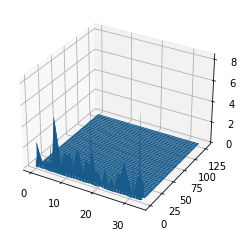

In [3]:
def get_spectrum(sample):
    assert sample.shape == (8000,)

    sample_offset = np.mean(sample)
    sample = sample - sample_offset

    sample_scale = np.sqrt(np.sum(sample**2))
    if sample_scale <= 0:
        sample_scale = 1
    sample = sample / sample_scale

    f, t, Sxx = sig.spectrogram(sample, dataloader.UNIFORM_SAMPLE_RATE)
    return Sxx, (sample_scale, sample_offset)

sample = random.choice(random.choice(list(raw_dataset.values())))
spectrum, spectrum_params = get_spectrum(sample)

print('spectrum min', np.min(spectrum))
print('spectrum max', np.max(spectrum))
print('spectrum mean', np.mean(spectrum))
print('spectrum std', np.std(spectrum))

print()
print('spectrum params', spectrum_params)

def plot3d(spectrum):
    assert len(spectrum.shape) == 2
    fig = plt.figure()
    p = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(spectrum.shape[1]), range(spectrum.shape[0]))
    p.plot_surface(x, y, spectrum)
    plt.show()
plot3d(spectrum)

8.336219252669252e-06


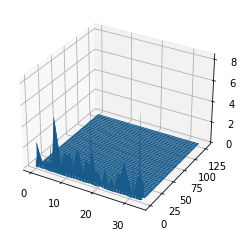

new point [2, 33, 1.9145061742165126e-05]
7.005785391811514e-06


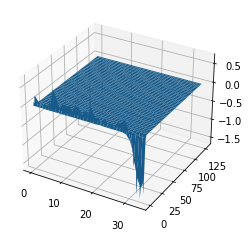

new point [2, 18, 1.727485505398363e-05]
5.266812877380289e-06


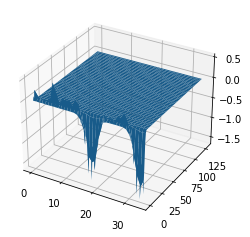

new point [2, 6, 1.5353884009527974e-05]
2.8759916403942043e-06


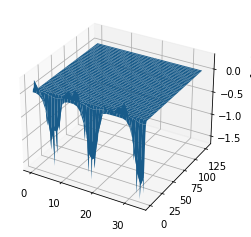

new point [2, 26, 7.96952735981904e-06]
2.65512926489464e-06


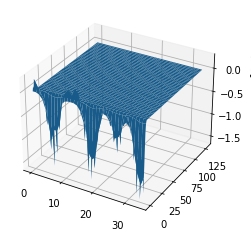

new point [3, 12, 6.936322733963607e-06]
2.2852764232084155e-06


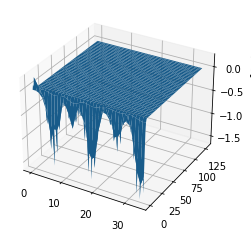

new point [3, 0, 2.3559273358841892e-06]
8.94896800218703e-07


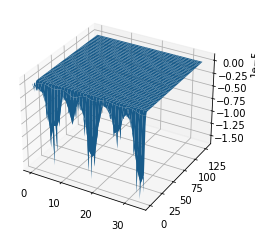

new point [12, 6, 1.073160049713806e-08]
8.94896800218703e-07


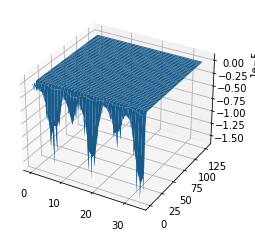

new point [12, 29, 1.034472774108508e-08]
8.94896800218703e-07


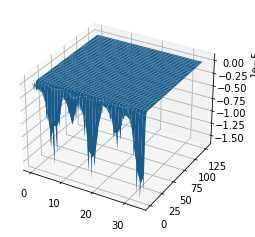

array([[2.00000000e+00, 3.30000000e+01, 1.91450617e-05],
       [2.00000000e+00, 1.80000000e+01, 1.72748551e-05],
       [2.00000000e+00, 6.00000000e+00, 1.53538840e-05],
       [2.00000000e+00, 2.60000000e+01, 7.96952736e-06],
       [3.00000000e+00, 1.20000000e+01, 6.93632273e-06],
       [3.00000000e+00, 0.00000000e+00, 2.35592734e-06],
       [1.20000000e+01, 6.00000000e+00, 1.07316005e-08],
       [1.20000000e+01, 2.90000000e+01, 1.03447277e-08]])

In [4]:
def decompose_gaussians(spectrum, variances, *, log = False):
    assert len(spectrum.shape) == 2
    spectrum = torch.tensor(spectrum).cuda()
    
    res = []

    if log:
        print(torch.max(spectrum).item())
        plot3d(np.array(spectrum.cpu()))

    for variance in variances:
        r = [min(2 * variance, dim - 1) for dim in spectrum.shape]
        x, y = torch.meshgrid(torch.tensor(range(-r[0], r[0] + 1)).cuda(), torch.tensor(range(-r[1], r[1] + 1)).cuda())
        g = torch.exp(-(x**2 + y**2) / variance)
        e = torch.nn.functional.conv2d(spectrum.reshape(1, 1, *spectrum.shape), g.reshape(1, 1, *g.shape), padding = 'same').reshape(spectrum.shape)
        assert spectrum.shape == e.shape, f'{spectrum.shape} -> {e.shape}'
        p = np.unravel_index(torch.argmax(e).item(), e.shape)
        assert len(p) == 2, f'{p}'
        m = e[p]
        res.append([*p, m.item()])
        x, y = torch.meshgrid(torch.tensor(range(spectrum.shape[0])).cuda(), torch.tensor(range(spectrum.shape[1])).cuda())
        assert x.shape == y.shape == spectrum.shape
        spectrum = spectrum - m * torch.exp(-((x-p[0])**2 + (y-p[1])**2) / variance)
        
        if log:
            print('new point', res[-1])
            print(torch.max(spectrum).item())
            plot3d(np.array(spectrum.cpu()))

    return np.array(res)

decompose_gaussians(spectrum, [5] * 8, log = True)

In [5]:
GAUSSIANS = 4
VARIANCE = 5

def prep_sample(x):
    spectrum, _ = get_spectrum(x)
    points = decompose_gaussians(spectrum, [VARIANCE] * GAUSSIANS) / np.array([*spectrum.shape, 1])
    assert points.shape == (GAUSSIANS, 3)
    
    t = np.sum(points[:,2])
    if t > 0:
        points[:,1] -= np.sum(points[:,1] * points[:,2]) / t
        points[:,2] /= np.max(points[:,2])
    
    return points

count = [0]
total = sum([len(v) for k, v in raw_dataset.items()])
def logging_prep_sample(x):
    count[0] += 1
    print(f'\rprocessing samples: {count[0]}/{total} ({100 * count[0] / total:0.2f}%)                         ', end = '')
    return prep_sample(x)

print(f'prepping data with GUASSIANS={GAUSSIANS}, VARIANCE={VARIANCE}')
dataset = { k: [logging_prep_sample(x) for x in v] for k, v in raw_dataset.items() }
print()
print({ k: len(v) for k, v in dataset.items() })

prepping data with GUASSIANS=4, VARIANCE=5
processing samples: 53469/53469 (100.00%)                         
{'Train': 895, 'Clapping': 546, 'BackgroundSounds': 8192, 'Laughing': 216, 'Whistle': 21, 'Whistling': 22, 'Horn': 1146, 'Dog': 2768, 'Siren': 2363, 'BirdChirp': 1299, 'Noise': 1950, 'Scream': 36, 'Aircraft': 1119, 'Crow': 621, 'Sneezing': 154, 'Rooster': 402, 'Wind': 1408, 'Gunshot': 8, 'Frog': 3608, 'CarDoor': 452, 'Engine': 5845, 'VehicleExhaust': 292, 'Coughing': 736, 'Cat': 242, 'Bell': 702, 'Beeping': 98, 'Thunder': 488, 'Unknown': 293, 'Insects': 1986, 'Sheep': 191, 'Basketball': 752, 'Drums': 6193, 'Cow': 168, 'GunNoise': 2448, 'PowerTool': 1537, 'GlassBreak': 982, 'Skateboarding': 76, 'Jackhammer': 2882, 'HandSaw': 332}


In [6]:
benchmark_dataset = dict(random.sample([(k,v) for k,v in dataset.items() if len(v) >= 256], 10))
print({ k: len(v) for k, v in benchmark_dataset.items() })
max_clusters = 32

def benchmark(filter_class, filter_thresh):
    print(f'bench: {filter_class.__name__}')
    print()
    print('heterogeneous class tests:')
    vals = []
    for i in range(256):
        f = filter_class(max_clusters, filter_thresh)
        keeps = []
        reps = 30
        for rep in range(reps):
            for label, samples in benchmark_dataset.items():
                if f.insert(random.choice(samples)):
                    keeps.append(label)
        vals.append(100 * len(keeps) / len(benchmark_dataset) / reps)
#         print(f'iter {i:>4}: kept {len(keeps)}/{len(benchmark_dataset) * reps} ({vals[-1]:.2f}%)')
    print(f'mean: {np.mean(vals):>5.2f} std: {np.std(vals):>5.2f} med: {np.median(vals):>5.2f}')

    print()
    print('homogenous class tests:')
    vals = []
    for label, samples in benchmark_dataset.items():
        f = filter_class(max_clusters, filter_thresh)
        keeps = []
        reps = 300
        for rep in range(reps):
            if f.insert(random.choice(samples)):
                keeps.append(i)
        vals.append(100 * len(keeps) / reps)
        print(f'{label:>16}: kept {len(keeps):>4}/{reps} ({vals[-1]:>5.2f}%)')
    print(f'mean: {np.mean(vals):>5.2f} std: {np.std(vals):>5.2f}')

def distance_metric(a, b):
    assert a.shape[-2:] == (GAUSSIANS, 3)
    assert b.shape == (GAUSSIANS, 3)
    
    w = np.array([1, 1, 1])
    a = a * w
    b = b * w
    
    return np.sum([np.min(np.sum((a - bi)**2, axis = -1), axis = -1) for bi in b])

class ClusterFilter:
    def __init__(self, max_clusters, thresh):
        self.embeds = np.zeros((max_clusters, GAUSSIANS, 3))
        self.weights = np.zeros((max_clusters,))
        self.max_clusters = max_clusters
        self.base_radius = thresh
        self.max_weight = 16
    def insert(self, embed):
        assert embed.shape == self.embeds.shape[1:] and self.embeds.shape[0] == self.max_clusters and self.weights.shape == (self.max_clusters,)
        dists = distance_metric(self.embeds, embed)
        close = dists <= np.sqrt(self.weights) * self.base_radius
        
        if np.any(close):
#             self.weights[close] = np.minimum(self.weights[close] + 1, self.max_weight)

            self.embeds = np.concatenate([
                self.embeds[~close],
                self.embeds[close],
            ])
            self.weights = np.concatenate([
                self.weights[~close],
                np.minimum(self.weights[close] + 1, self.max_weight),
            ])

            return False
        else:
            self.embeds = np.concatenate([
                self.embeds[1:],
                [ embed ],
            ])
            self.weights = np.concatenate([
                self.weights[1:],
                [ 1 ],
            ])
            return True

benchmark(ClusterFilter, 9)

{'Coughing': 736, 'BackgroundSounds': 8192, 'Rooster': 402, 'Wind': 1408, 'Noise': 1950, 'Bell': 702, 'Dog': 2768, 'Engine': 5845, 'Unknown': 293, 'Frog': 3608}
bench: ClusterFilter

heterogeneous class tests:
mean: 95.97 std: 14.20 med: 100.00

homogenous class tests:
        Coughing: kept  300/300 (100.00%)
BackgroundSounds: kept   70/300 (23.33%)
         Rooster: kept   34/300 (11.33%)
            Wind: kept   35/300 (11.67%)
           Noise: kept   40/300 (13.33%)
            Bell: kept   38/300 (12.67%)
             Dog: kept   63/300 (21.00%)
          Engine: kept   33/300 (11.00%)
         Unknown: kept   32/300 (10.67%)
            Frog: kept   58/300 (19.33%)
mean: 23.43 std: 25.90
